In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(42)

In [3]:
# Define dataset paths
DATASET_DIR = "./Teeth_Dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, "Training")
VAL_DIR = os.path.join(DATASET_DIR, "Validation")
TEST_DIR = os.path.join(DATASET_DIR, "Testing")

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# Validation and test data without augmentation
val_test_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=False, classes=list(train_generator.class_indices.keys())  
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [7]:
# Load the MobileNetV2 model without the classification head
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
# Fine-tuning new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(len(train_generator.class_indices), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

In [9]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
# Model Callbacks
checkpoint = ModelCheckpoint('mobilenetv2_fine_tuned.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [11]:
# Train the model
history = model.fit(
    train_generator, validation_data=val_generator, epochs=30,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/30


C:\Users\Computec\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.2426 - loss: 2.1859
Epoch 1: val_loss improved from inf to 1.28024, saving model to mobilenetv2_fine_tuned.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 92s 860ms/step - accuracy: 0.2432 - loss: 2.1835 - val_accuracy: 0.5486 - val_loss: 1.2802 - learning_rate: 1.0000e-04
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.4594 - loss: 1.5044
Epoch 2: val_loss improved from 1.28024 to 1.04241, saving model to mobilenetv2_fine_tuned.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 816ms/step - accuracy: 0.4595 - loss: 1.5039 - val_accuracy: 0.6401 - val_loss: 1.0424 - learning_rate: 1.0000e-04
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.5541 - loss: 1.2538
Epoch 3: val_loss improved from 1.04241 to 0.88716, saving model to mobilenetv2_fine_tuned.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 821ms/step - accuracy: 0.5542 - loss: 1.2535 - val_accuracy: 0.7004 - val_loss: 0.8872 - learning_rate: 1.0000e-04
Epoch 4/30
97/97 ━━━━━━━━━━━

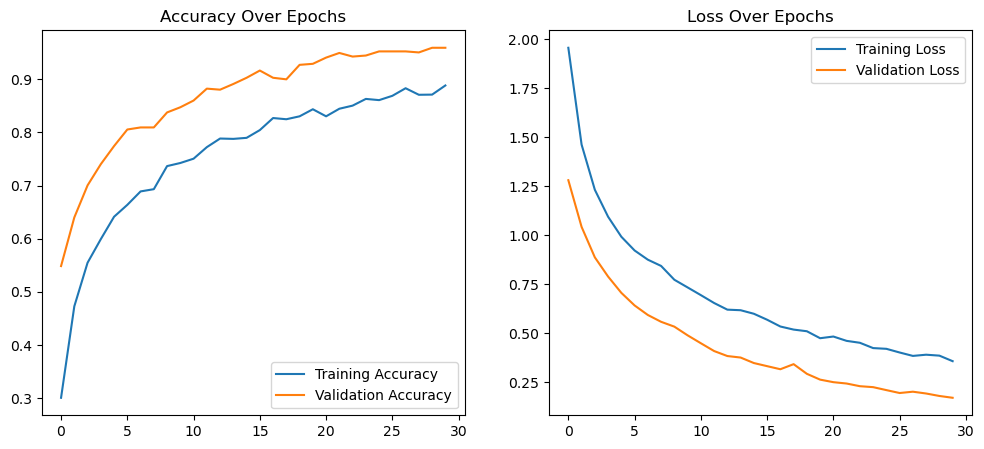

In [12]:
# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [13]:
# Evaluate on test data
model = keras.models.load_model('mobilenetv2_fine_tuned.keras')
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 473ms/step - accuracy: 0.9770 - loss: 0.1293
Test Loss: 0.1663, Test Accuracy: 0.9621


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 493ms/step


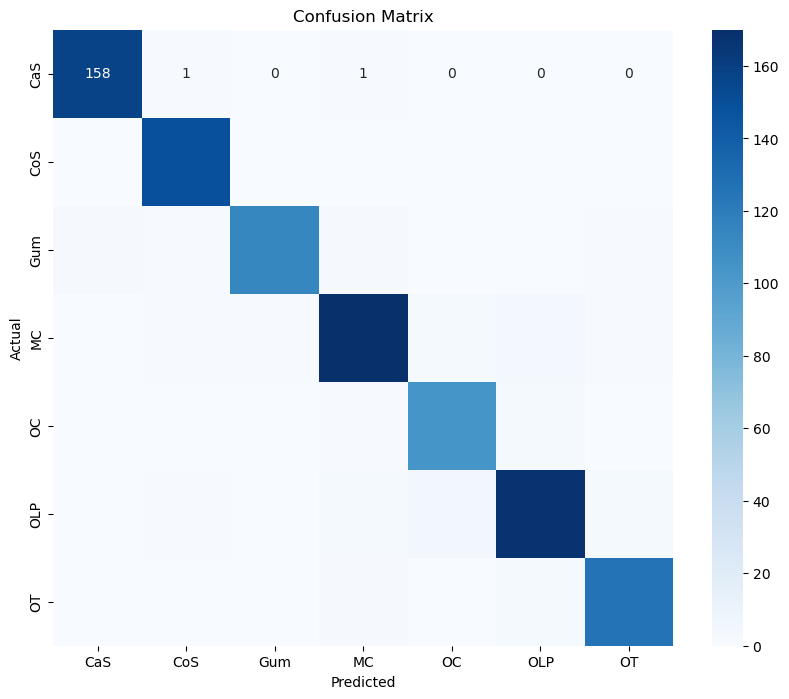

Classification Report:
              precision    recall  f1-score   support

         CaS       0.99      0.99      0.99       160
         CoS       0.97      1.00      0.99       149
         Gum       0.99      0.95      0.97       120
          MC       0.95      0.94      0.95       180
          OC       0.93      0.96      0.95       108
         OLP       0.94      0.93      0.94       180
          OT       0.96      0.96      0.96       131

    accuracy                           0.96      1028
   macro avg       0.96      0.96      0.96      1028
weighted avg       0.96      0.96      0.96      1028



In [14]:
# Predictions and confusion matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [15]:
# Save the trained model in TensorFlow's format
model.save("mobilenetv2_teeth_classifier.keras")
